In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
xgb_bohb_best = pd.read_pickle('models/xgb_bohb_best.pkl')
xgb_bohb_bal_best = pd.read_pickle('models/xgb_bohb_best_bal.pkl')

training_data_full= pd.read_parquet('data/parquet_files/training_data_rfm_alt.parquet')
training_data_full_bal= pd.read_parquet('data/parquet_files/training_data_rfm_balanced_alt.parquet')

_, _, _, y_test_full = train_test_split(training_data_full.drop(columns=['Flag']), training_data_full['Flag'], test_size=0.2, random_state=42)
X_test_sfs_xgb = pd.read_pickle('models/X_test_sfs_xgb.pkl')

_, _, _, y_test_full_bal = train_test_split(training_data_full_bal.drop(columns=['Flag']), training_data_full_bal['Flag'], test_size=0.2, random_state=42)
X_test_sfs_xgb_bal = pd.read_pickle('models/X_test_sfs_xgb_balanced.pkl')

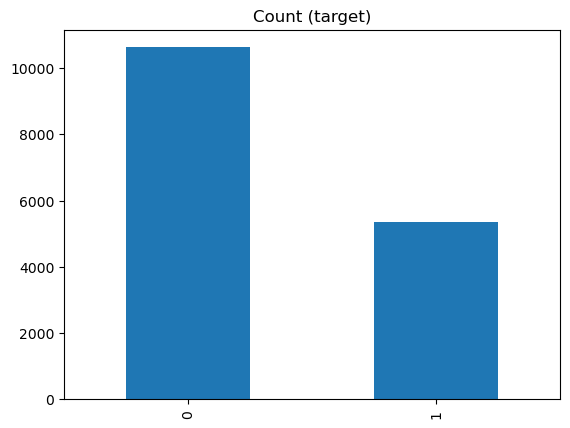

In [4]:
# plot value counts of y_test_full
y_test_full.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

Accuracy (BOHB):  0.9793021510755378
Precision (BOHB):  0.949928469241774
Recall (BOHB):  0.9904903971657655
F1 (BOHB):  0.9697854860794158
False Positive Rate (BOHB):  0.02634302380280365
False Negative Rate (BOHB):  0.009509602834234571
Accuracy (BOHB Balanced):  0.9759894954042394
Precision (BOHB Balanced):  0.9605168700646087
Recall (BOHB Balanced):  0.9933184855233853
F1 (BOHB Balanced):  0.9766423357664233
False Positive Rate (BOHB Balanced):  0.041714069017823284
False Negative Rate (BOHB Balanced):  0.0066815144766146995


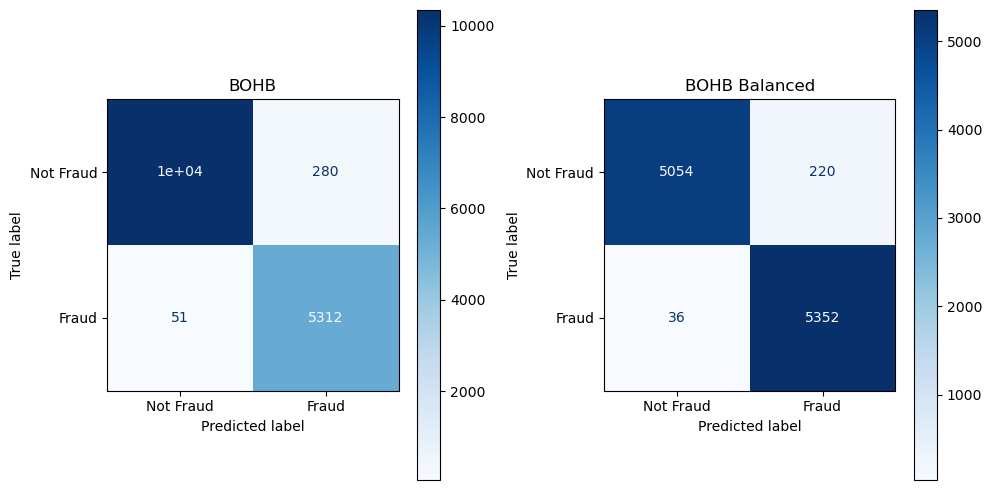

In [5]:
def get_metrics_and_cm(model, X_test, y_test, method):
    y_pred = model.predict(X_test)
    print(f'Accuracy ({method}): ', accuracy_score(y_test, y_pred))
    print(f'Precision ({method}): ', precision_score(y_test, y_pred))
    print(f'Recall ({method}): ', recall_score(y_test, y_pred))
    print(f'F1 ({method}): ', f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print(f'False Positive Rate ({method}): ', fpr)
    print(f'False Negative Rate ({method}): ', fnr)
    
    return cm

models_info = [
    (xgb_bohb_best, X_test_sfs_xgb, y_test_full, 'BOHB'),
    (xgb_bohb_bal_best, X_test_sfs_xgb_bal, y_test_full_bal, 'BOHB Balanced')
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
axes = axes.flatten()

for idx, (model, X_test, y_test, label) in enumerate(models_info):
    cm = get_metrics_and_cm(model, X_test, y_test, label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues)
    axes[idx].set_title(label)

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

test_set = pd.read_parquet('data/parquet_files/test_df_alt.parquet')
scam_addresses_in_train_test = pd.read_pickle('data/pickle_files/scam_addresses_in_train_test_alt.pkl')

test_set['Flag'] = test_set['address'].apply(lambda x: 1 if x in scam_addresses_in_train_test else 0)

X_test_sfs_xgb = pd.read_pickle('models/X_test_sfs_xgb.pkl')
chosen_columns = X_test_sfs_xgb.columns
X_test_sfs_xgb_bal = pd.read_pickle('models/X_test_sfs_xgb_balanced.pkl')
chosen_columns_bal = X_test_sfs_xgb_bal.columns

fill_values = {'median_recency_out':0, 'median_recency_in':0, 'num_outliers_eth_out':0, 'num_outliers_eth_in': 0,
               'daily_from_gini_index': -1, 'daily_to_gini_index': -1, 'weekly_from_gini_index': -1, 
               'weekly_to_gini_index': -1, 'daily_total_gini_index': -1, 'weekly_total_gini_index': -1}
test_set = test_set.fillna(value=fill_values)
test_set_pred = test_set[chosen_columns.append(pd.Index(['Flag']))]
test_set_pred_bal = test_set[chosen_columns_bal.append(pd.Index(['Flag']))]

In [7]:
X = test_set_pred.drop(columns=['Flag'])
y = test_set_pred['Flag']
X_bal = test_set_pred_bal.drop(columns=['Flag'])
y_bal = test_set_pred_bal['Flag']

In [8]:
pred_bohb = xgb_bohb_best.predict(X)
pred_bohb_proba = xgb_bohb_best.predict_proba(X)[:,1]
test_set['Predictions_BOHB'] = pred_bohb
test_set['Predictions_Proba_BOHB'] = pred_bohb_proba

pred_bohb_bal = xgb_bohb_bal_best.predict(X_bal)
pred_bohb_bal_proba = xgb_bohb_bal_best.predict_proba(X_bal)[:,1]
test_set['Predictions_BOHB_Bal'] = pred_bohb_bal
test_set['Predictions_Proba_BOHB_Bal'] = pred_bohb_bal_proba

Percentage of Fraud Accounts (Predictions_BOHB):  2.94 %
Percentage of Non-Fraud Accounts (Predictions_BOHB):  97.06 %
Number of Fraud Accounts (Predictions_BOHB):  107272
Number of Non-Fraud Accounts (Predictions_BOHB):  3544861
Number of known fraud accounts (Predictions_BOHB):  403
Number of known fraud accounts flagged correctly (Predictions_BOHB):  48
Number of known fraud accounts flagged incorrectly (Predictions_BOHB):  355
Unknown fraud accounts flagged (Predictions_BOHB):  107224


Percentage of Fraud Accounts (Predictions_BOHB_Bal):  4.54 %
Percentage of Non-Fraud Accounts (Predictions_BOHB_Bal):  95.46 %
Number of Fraud Accounts (Predictions_BOHB_Bal):  165767
Number of Non-Fraud Accounts (Predictions_BOHB_Bal):  3486366
Number of known fraud accounts (Predictions_BOHB_Bal):  403
Number of known fraud accounts flagged correctly (Predictions_BOHB_Bal):  54
Number of known fraud accounts flagged incorrectly (Predictions_BOHB_Bal):  349
Unknown fraud accounts flagged (Predictio

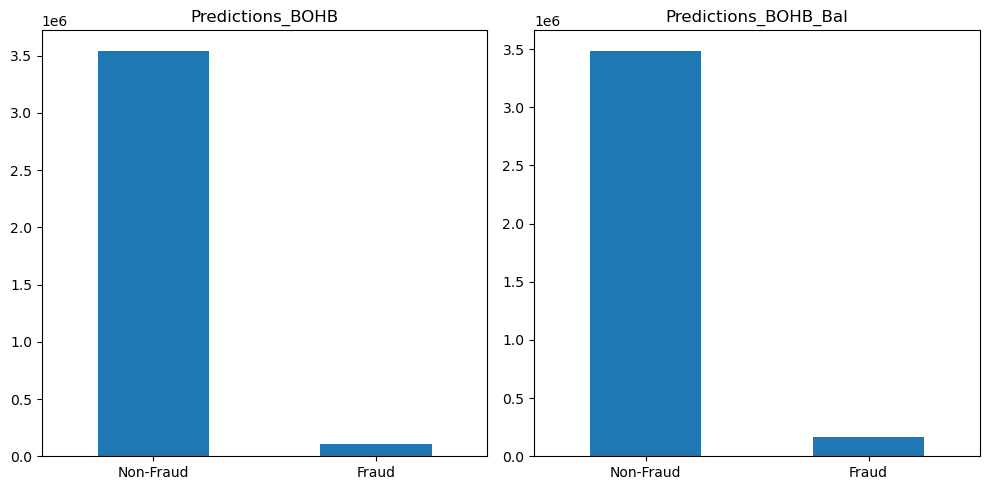

In [9]:
predictions_columns = ['Predictions_BOHB', 'Predictions_BOHB_Bal']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, column in enumerate(predictions_columns):
    
    # Show proportion of fraud vs non-fraud accounts
    test_set[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{column}")
    # Rename x label ticks
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Non-Fraud", "Fraud"], rotation=0)

    # Print percentage of fraud vs non-fraud accounts
    print(f"Percentage of Fraud Accounts ({column}): ", round(test_set[column].value_counts()[1] / len(test_set) * 100, 2), "%")
    print(f"Percentage of Non-Fraud Accounts ({column}): ", round(test_set[column].value_counts()[0] / len(test_set) * 100, 2), "%")

    # Print number of fraud vs non-fraud accounts
    print(f"Number of Fraud Accounts ({column}): ", test_set[column].value_counts()[1])
    print(f"Number of Non-Fraud Accounts ({column}): ", test_set[column].value_counts()[0])

    # Print additional information
    print(f"Number of known fraud accounts ({column}): ", test_set['Flag'].value_counts()[1])
    print(f"Number of known fraud accounts flagged correctly ({column}): ", test_set[(test_set['Flag'] == 1) & (test_set[column] == 1)].shape[0])
    print(f"Number of known fraud accounts flagged incorrectly ({column}): ", test_set[(test_set['Flag'] == 1) & (test_set[column] == 0)].shape[0])
    print(f"Unknown fraud accounts flagged ({column}): ", test_set[(test_set['Flag'] == 0) & (test_set[column] == 1)].shape[0])
    print("\n")

plt.tight_layout()
plt.show()

In [10]:
two_month_df = pd.read_parquet('data/parquet_files/train_two_month_with_scam_df_alt.parquet')
scam_addresses_in_train_test = pd.read_pickle('data/pickle_files/scam_addresses_in_train_test_alt.pkl')
fill_values = {'median_recency_out':0, 'median_recency_in':0, 'num_outliers_eth_out':0, 'num_outliers_eth_in': 0,
               'daily_from_gini_index': -1, 'daily_to_gini_index': -1, 'weekly_from_gini_index': -1, 
               'weekly_to_gini_index': -1, 'daily_total_gini_index': -1, 'weekly_total_gini_index': -1}
two_month_df = two_month_df.fillna(value=fill_values)
two_month_df['Flag'] = two_month_df['address'].apply(lambda x: 1 if x in scam_addresses_in_train_test else 0)

In [11]:
two_month_predictions_df = two_month_df[chosen_columns_bal.append(pd.Index(['Flag']))]
X_two_month = two_month_predictions_df.drop(columns=['Flag'])
y_two_month = two_month_predictions_df['Flag']
two_month_pred_bohb = xgb_bohb_bal_best.predict(X_two_month)
two_month_pred_bohb_proba = xgb_bohb_bal_best.predict_proba(X_two_month)[:,1]
two_month_df['Predictions_BOHB_Bal'] = two_month_pred_bohb
two_month_df['Predictions_Proba_BOHB_Bal'] = two_month_pred_bohb_proba
two_month_df['Flag_Predictions'] = two_month_df['Flag'].astype('str') + two_month_df['Predictions_BOHB_Bal'].astype('str')
grouped_pred = two_month_df.groupby('address').agg({'Predictions_BOHB_Bal': 'nunique'})
different_pred = grouped_pred[(grouped_pred['Predictions_BOHB_Bal'] > 1)]
grouped_pred_list = different_pred.index.tolist()
different_pred_df = two_month_df[two_month_df['address'].isin(grouped_pred_list)]
known_fraud_different_pred_df = different_pred_df[(different_pred_df['Flag']==1)]

In [12]:
print('Number of unique scam addresses May and June:', len(scam_addresses_in_train_test))
unique_fraud_addresses = known_fraud_different_pred_df['address'].unique().tolist()
print('Number of addresses flagged differently in 2 months ', len(unique_fraud_addresses))

Number of unique scam addresses May and June: 631
Number of addresses flagged differently in 2 months  21


In [13]:
dual_flagged_fraud_df = two_month_df[two_month_df['address'].isin(unique_fraud_addresses)]
dual_flagged_fraud_df = dual_flagged_fraud_df[['address', 'year_month', 'Flag', 'Predictions_BOHB_Bal' ]]
dual_flagged_fraud_df.sort_values(by=['address', 'year_month'], inplace=True)
dual_flagged_fraud_count = dual_flagged_fraud_df.groupby(['year_month', 'Flag', 'Predictions_BOHB_Bal']).size().reset_index(name='count')

print(dual_flagged_fraud_count)

  year_month  Flag  Predictions_BOHB_Bal  count
0    2022-05     1                     0     14
1    2022-05     1                     1      7
2    2022-06     1                     0      7
3    2022-06     1                     1     14


Percentage of Fraud Accounts:  4.67 %
Percentage of Non-Fraud Accounts:  95.33 %
Number of Fraud Accounts:  271922
Number of Non-Fraud Accounts:  5553076
Number of known fraud accounts:  403
Number of known fraud accounts flagged correctly:  54
Number of known fraud accounts flagged incorrectly:  349
Unknown fraud accounts flagged:  271868


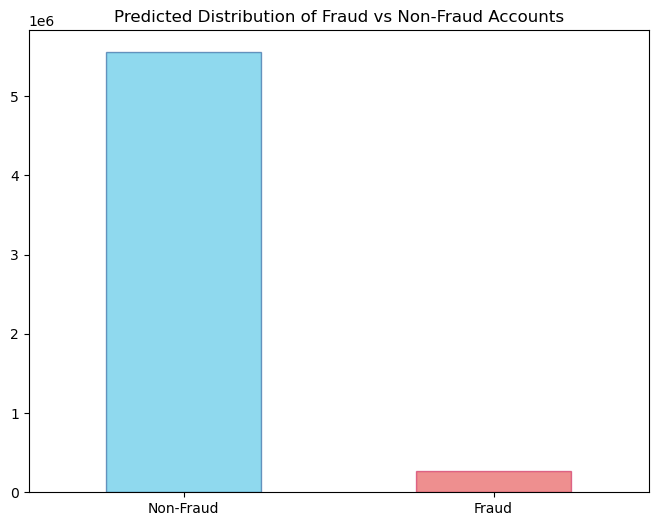

In [60]:
june_accounts_df = two_month_df[two_month_df['year_month']=='2022-06']
all_june_accounts_df = pd.concat([test_set, june_accounts_df])
all_june_accounts_df.drop(columns=['Predictions_BOHB', 'Predictions_Proba_BOHB'], inplace=True)
all_june_accounts_df.rename(columns={'Predictions_BOHB_Bal':'Predictions', 'Predictions_Proba_BOHB_Bal': 'Predictions_Proba'}, inplace=True)
all_june_accounts_df.drop_duplicates(subset=['address'], keep='last', inplace=True)
all_june_accounts_df.drop(columns=['Flag_Predictions'], inplace=True)

#print percentage of fraud vs non-fraud accounts
print("Percentage of Fraud Accounts: ", round(all_june_accounts_df['Predictions'].value_counts()[1]/len(all_june_accounts_df) * 100,2), "%")
print("Percentage of Non-Fraud Accounts: ", round(all_june_accounts_df['Predictions'].value_counts()[0]/len(all_june_accounts_df) * 100,2), "%")

#print number of fraud vs non-fraud accounts
print("Number of Fraud Accounts: ", all_june_accounts_df['Predictions'].value_counts()[1])
print("Number of Non-Fraud Accounts: ", all_june_accounts_df['Predictions'].value_counts()[0])
print('Number of known fraud accounts: ', all_june_accounts_df['Flag'].value_counts()[1])
print('Number of known fraud accounts flagged correctly: ', all_june_accounts_df[(all_june_accounts_df['Flag']==1) & (all_june_accounts_df['Predictions']==1)].shape[0])
print('Number of known fraud accounts flagged incorrectly: ', all_june_accounts_df[(all_june_accounts_df['Flag']==1) & (all_june_accounts_df['Predictions']==0)].shape[0])
print('Unknown fraud accounts flagged: ', all_june_accounts_df[(all_june_accounts_df['Flag']==0) & (all_june_accounts_df['Predictions']==1)].shape[0])
all_june_accounts_df.to_parquet('data/parquet_files/all_june_accounts_df.parquet')

labels = ['Non-Fraud', 'Fraud']
value_counts = all_june_accounts_df['Predictions'].value_counts()
all_june_accounts_df['Predictions'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette=["#00C5FF", "#FF0000"], edgecolor=["#003986",'#C50045'], alpha=0.5)
plt.title("Predicted Distribution of Fraud vs Non-Fraud Accounts")
plt.xticks([0,1], labels, rotation=0)

bar_width = 0.5 
for i, bar in enumerate(ax.patches):
    x = bar.get_x() 
    center = x + bar.get_width() / 2. 
    new_x = center - bar_width / 2.
    bar.set_x(new_x)
    bar.set_width(bar_width)

plt.show()

In [120]:
all_june_accounts_df = pd.read_parquet('data/parquet_files/all_june_accounts_df.parquet')

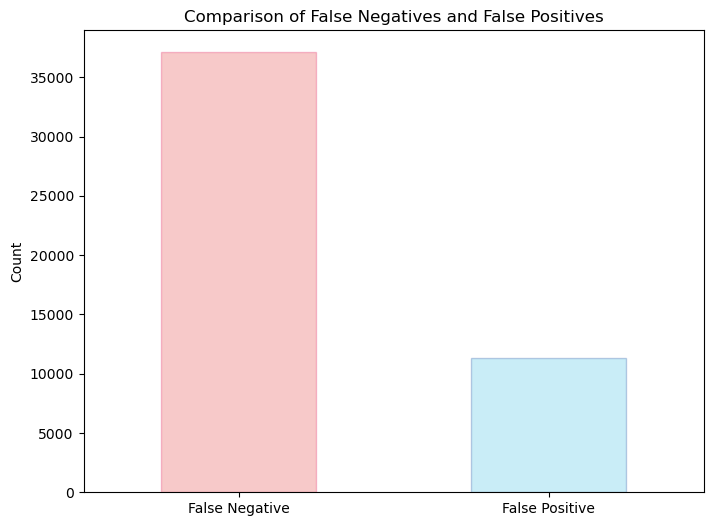

In [64]:
labels = ['False Negative', 'False Positive']
values = [37102, 11343]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=labels, y=values, palette=["#FF3333", "#33D2FF"], edgecolor=["#E63370", "#335BA6"], alpha=0.3)

bar_width = 0.5 
for i, bar in enumerate(ax.patches):
    x = bar.get_x() 
    center = x + bar.get_width() / 2. 
    new_x = center - bar_width / 2.
    bar.set_x(new_x)
    bar.set_width(bar_width)

plt.title('Comparison of False Negatives and False Positives')
plt.ylabel('Count')
plt.show()

In [47]:
confidence_interval_df = pd.read_parquet('data/parquet_files/confidence_interval_df.parquet') 
confidence_interval_df

,address_id,normal_ci,fraud_ci
0,53,"[0.9996159806847572, 0.9998324260115623]","[0.00016757587909523863, 0.0003840261728328187]"
1,78,"[0.9919156327843666, 0.9950084283947944]","[0.004991549311671406, 0.008084370894357562]"
2,85,"[0.9296048194169998, 0.9695502176880837]","[0.030449758190661667, 0.07039517350494862]"
3,210,"[0.9988980516791344, 0.999684925377369]","[0.0003150852491671685, 0.0011019390571163966]"
4,243,"[0.9999576777219772, 0.9999856695532798]","[1.432965832464106e-05, 4.231194325257092e-05]"
...,...,...,...
5824993,5963049,"[0.011198385059833527, 0.014482009410858154]","[0.9855179905891418, 0.9888016149401665]"
5824994,5963421,"[0.9978009849786759, 0.9987680345773697]","[0.0012319644272793084, 0.0021990250563248986]"
5824995,5963439,"[0.9771861955523491, 0.9904810816049576]","[0.009518923796713352, 0.022813788009807465]"
5824996,5963442,"[0.0440219834446907, 0.04563431292772293]","[0.9543656870722771, 0.9559780165553093]"


In [14]:
flagged_june_fraud = all_june_accounts_df[(all_june_accounts_df['Predictions']==1)].sort_values(by='Predictions_Proba', ascending=False)
flagged_june_fraud.to_parquet('data/parquet_files/flagged_fraud.parquet')

In [134]:
from sqlalchemy import create_engine
import pymysql
import db_connection as dbconn

config_sql = dbconn.config_sql
engine_sql = create_engine(f"mysql+pymysql://{config_sql['user']}:{config_sql['password']}@{config_sql['host']}:{config_sql['port']}/{config_sql['database']}")
# address_df = pd.read_sql('SELECT * FROM Addresses', con=engine_sql)

flagged_june_accounts_ids = pd.read_parquet('data/parquet_files/flagged_fraud.parquet')['address_id'].unique().tolist()
print(len(flagged_june_accounts_ids))
with (open('data/pickle_files/flagged_june_accounts_ids.pkl', 'wb')) as f:
    pickle.dump(flagged_june_accounts_ids, f)

271922


In [135]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum

flagged_june_accounts_ids = pd.read_pickle('data/pickle_files/flagged_june_accounts_ids.pkl')

db_config = dbconn.config_sql
# Create a SparkSession
spark = SparkSession.builder \
    .appName("process_tx") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

url = f"jdbc:mariadb://{db_config['host']}:{db_config['port']}/{db_config['database']}"
user = db_config['user']
password = db_config['password']
transactions_df = spark.read.format('jdbc').options(url=url, dbtable='Transactions', user=user, password=password).load()

all_eth_transactions = transactions_df.filter((transactions_df['asset'] == 'ETH') & (transactions_df['category_id'] != 3))
all_eth_transactions = all_eth_transactions.na.fill({'asset_value': 0})
# Convert 'asset_value' to float
all_eth_transactions = all_eth_transactions.withColumn('asset_value', all_eth_transactions['asset_value'].cast('float'))
total_tx_volume_by_hash = all_eth_transactions.groupby('tx_hash').agg(spark_sum('asset_value').alias('sum_asset_value')).sort('sum_asset_value', ascending=False)
# Filter the transactions
potential_fraud_transactions_df = transactions_df.filter(transactions_df['from_id'].isin(flagged_june_accounts_ids) | transactions_df['to_id'].isin(flagged_june_accounts_ids))

23/08/10 01:39:32 WARN Utils: Your hostname, NatRng-MBP.local resolves to a loopback address: 127.0.0.1; using 10.200.175.211 instead (on interface en0)
23/08/10 01:39:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/10 01:39:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [136]:
total_tx_volume_by_hash.write.mode('overwrite').parquet('data/parquet_files/total_tx_volume_by_hash.parquet')
potential_fraud_transactions_df.write.mode('overwrite').parquet('data/parquet_files/potential_fraud_transactions_df.parquet')
all_eth_transactions.write.mode("overwrite").parquet('data/parquet_files/all_eth_transactions_df.parquet')

23/08/10 01:49:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


In [19]:
unique_tx_hash = transactions_df.select('tx_hash').distinct()
total_transactions = [row.tx_hash for row in unique_tx_hash.select('tx_hash').collect()]
with open('data/pickle_files/total_transactions.pkl', 'wb') as f:
    pickle.dump(total_transactions, f)

potential_fraud_transactions_df = spark.read.parquet('data/parquet_files/potential_fraud_transactions_df.parquet')
unique_potential_fraud_tx_hash = potential_fraud_transactions_df.select('tx_hash').distinct()
potential_fraud_transactions = [row.tx_hash for row in unique_potential_fraud_tx_hash.select('tx_hash').collect()]
with open('data/pickle_files/potential_fraud_transactions.pkl', 'wb') as f:
    pickle.dump(potential_fraud_transactions, f)

In [20]:
total_transactions = pd.read_pickle('data/pickle_files/total_transactions.pkl')
potential_fraud_transactions = pd.read_pickle('data/pickle_files/potential_fraud_transactions.pkl')
potential_fraud_transactions_df = pd.read_parquet('data/parquet_files/potential_fraud_transactions_df.parquet')
total_tx_volume_by_hash = pd.read_parquet('data/parquet_files/total_tx_volume_by_hash.parquet')

In [21]:
len(potential_fraud_transactions_df)

2591935

In [22]:
eth_transactions_potential_fraud = potential_fraud_transactions_df[(potential_fraud_transactions_df['asset'] == 'ETH') & (potential_fraud_transactions_df['category_id'] != 3)]
eth_transactions_potential_fraud.loc[:, 'asset_value'].fillna(0, inplace=True)
eth_transactions_potential_fraud.loc[:, 'asset_value'] = eth_transactions_potential_fraud.loc[:, 'asset_value'].astype('float64')
eth_transactions_potential_fraud.groupby('tx_hash')['asset_value'].sum().sort_values(ascending=False).head(50)

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_90175/1964743359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_transactions_potential_fraud.loc[:, 'asset_value'].fillna(0, inplace=True)
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_90175/1964743359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_transactions_potential_fraud.loc[:, 'asset_value'] = eth_transactions_potential_fraud.loc[:, 'asset_value'].astype('float64')
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_90175/1964743359.py:3: DeprecationWarning: In

tx_hash
0xa25724d1cb83e399e6c1d203c295bb84b01ce937df5db66bf757f83fc40ad0d5    115204.000000
0xd2a27443f807eb73719cccf6f89357b65aa9591de7873ed2f1630e3fde8ecfdb     17454.998047
0x8ea57464298167c6ae81dcd479418d0db7dd292d5c1bfe3789cb45efc21771ec      9894.997070
0x60dc90e04b17e473c3e843f81b9f616bcf3fcd14c38ec40f209cc4e4a1fee793      7209.999023
0x1e35d2c0d059ae87c7844e66bbb281edbdff37772de6864fcc600aa7ae007c36      6250.000000
0x6208bdf8cb3bc61aec392920e1759f983580b6cc3b6d6a1011b19b9432b99696      5840.000000
0xd65d280e2742d937a6a8aaf070b5c09a6d1d0ae2c7ddd8abd204e014003228cb      5824.000000
0x63041801d6cb2364cc9b10d1aa2644db1a4dcd081b32c5a7f477279a0bcbe369      5791.000000
0x690d2e69fc93c5ab4cb39607d5770e7318f814769f358db60a068ee92b84483b      5470.999023
0x57577f95a9f3e106b271b01c0e01be8e2dd0bad903f7a3132d621e0d31d86e46      5368.919922
0xbbb6a9ec408ea8433f5cb3ea53a77d30d310817383d0046b2107b61c9e6c1a40      5282.000000
0x254502133d28ba4c6a875667f0c79416291b0e312fab38e1538dfdc9704c04ec  

In [23]:
potential_fraud_volume = eth_transactions_potential_fraud.groupby('tx_hash')['asset_value'].sum().sum()
total_volume = total_tx_volume_by_hash['sum_asset_value'].sum()

print('Potential Fraud Volume: ', potential_fraud_volume)
print('Total Volume: ', total_volume)

print('Percentage of Potential Fraud Volume: ', potential_fraud_volume/total_volume * 100)

Potential Fraud Volume:  537816.3782928069
Total Volume:  90353834.84726812
Percentage of Potential Fraud Volume:  0.5952335937947939


In [ ]:
import pandas as pd
import networkx as nx
import os
import community as community_louvain
import random
random.seed(42)

if not os.path.exists('data/graph_files'):
    os.makedirs('data/graph_files')

eth_tx_df = pd.read_parquet('data/parquet_files/all_eth_transactions_df.parquet')
eth_tx_df = eth_tx_df[eth_tx_df['to_id'].isnull()==False]
eth_tx_df['to_id'] = eth_tx_df['to_id'].astype('int64')
eth_tx_df = eth_tx_df.fillna(value={'asset_value': 0})
eth_tx_df = eth_tx_df[eth_tx_df['asset'].isnull()==False]
#encode asset column
eth_tx_df['asset'] = eth_tx_df['asset'].astype('category')
eth_tx_df = eth_tx_df[['from_id', 'to_id', 'asset_value', 'asset', 'category_id']]
eth_tx_df = eth_tx_df[(eth_tx_df['asset']=='ETH') & (eth_tx_df['category_id']!=3)]
eth_tx_df = eth_tx_df.fillna(value={'asset_value': 0})
eth_tx_df['asset_value'] = eth_tx_df['asset_value'].astype('float')
agg_eth_df = eth_tx_df.groupby(['from_id', 'to_id'], as_index=False).agg({'asset_value': 'sum'})

G = nx.from_pandas_edgelist(agg_eth_df, 'from_id', 'to_id', edge_attr='asset_value', create_using=nx.DiGraph())

nx.write_gexf(G, 'data/graph_files/eth_graph.gexf')

In [3]:
component_df = pd.read_parquet('data/graph_files/eth_component_df.parquet')
components_grouped = component_df.groupby('component_id').agg({'node_id': 'count'}).reset_index().rename(columns={'node_id': 'count'})
components_grouped.sort_values('count', ascending=False).head(10)
components_grouped.sum()

component_id    3596664891
count              4973333
dtype: int64

In [4]:
partition_df = pd.read_parquet('data/graph_files/eth_partition_df.parquet')
partition_grouped = partition_df.groupby('community_id').agg({'node_id': 'count'}).reset_index().rename(columns={'node_id': 'count'})
partition_grouped.sort_values('count', ascending=False).head(10)
partition_grouped.sum()

community_id    4232595
count           4775938
dtype: int64

In [5]:
eth_df_graph_stats = pd.read_parquet('data/graph_files/eth_centrality_df_full.parquet')
filtered_eth_df_graph_stats = eth_df_graph_stats[eth_df_graph_stats['component_id'].isnull()==False]
filtered_eth_df_graph_stats['component_id'] = filtered_eth_df_graph_stats['component_id'].astype('int64')
filtered_eth_df_graph_stats = eth_df_graph_stats[eth_df_graph_stats['community_id'].isnull()==False]
filtered_eth_df_graph_stats['community_id'] = filtered_eth_df_graph_stats['community_id'].astype('int64')

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_4702/707839800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eth_df_graph_stats['component_id'] = filtered_eth_df_graph_stats['component_id'].astype('int64')
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_4702/707839800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eth_df_graph_stats['community_id'] = filtered_eth_df_graph_stats['community_id'].astype('int64')


In [6]:
#count is null eth_df_graph_stats
filtered_eth_df_graph_stats.count()

node_id              4775938
pagerank             4775938
degree_centrality    4775938
weighted_degree      4065590
in_degree            4775938
out_degree           4775938
component_id         4775938
community_id         4775938
dtype: int64

In [7]:
num_nodes_in_components = filtered_eth_df_graph_stats.groupby('component_id')['node_id'].count().reset_index().rename(columns={'node_id': 'num_nodes'})
num_nodes_in_components

,component_id,num_nodes
0,0.0,4775938


In [8]:
num_communities = filtered_eth_df_graph_stats.groupby('community_id')['node_id'].count().reset_index().rename(columns={'node_id': 'num_nodes'})
num_communities.sum()

community_id    4232595
num_nodes       4775938
dtype: int64

In [9]:
flagged_june_accounts = pd.read_parquet('data/parquet_files/flagged_fraud.parquet')
june_accounts_fraud = all_june_accounts_df[all_june_accounts_df['Flag']==1]
june_accounts_fraud_ids = june_accounts_fraud['address_id'].unique().tolist()
flagged_june_accounts_fraud = flagged_june_accounts[flagged_june_accounts['Predictions']==1]
flagged_june_accounts_fraud_ids = flagged_june_accounts_fraud['address_id'].unique().tolist()
len(flagged_june_accounts_fraud_ids)

271922

In [10]:
flagged_june_accounts_fraud_ids_set = set(flagged_june_accounts_fraud_ids)
filtered_eth_df_graph_stats_set = set(filtered_eth_df_graph_stats['node_id'].values)

fraud_id_not_in_graph = list(flagged_june_accounts_fraud_ids_set - filtered_eth_df_graph_stats_set)
print(len(fraud_id_not_in_graph))
print(fraud_id_not_in_graph)

124048
[5242883, 1572868, 3670021, 2883592, 5767177, 1572874, 3932168, 5767180, 3670029, 3407883, 4456459, 5505046, 1572893, 786462, 1835043, 5767216, 5242929, 3932211, 3932215, 3670073, 3932217, 5767227, 5242939, 2359354, 5505085, 1310782, 2621504, 2883651, 1835077, 3932231, 4980807, 3145803, 1572939, 1572941, 1835083, 1835086, 2621523, 2359380, 5767255, 3407961, 3145818, 3932255, 5767270, 3145831, 4194408, 786537, 3670125, 2621550, 3932270, 3407988, 2621559, 2359415, 3670137, 1835130, 4980860, 1835132, 1835133, 1310847, 5243013, 786566, 2097288, 1048715, 3408013, 1048722, 1835158, 1310872, 5243033, 1835162, 3932317, 1048735, 2621599, 3670177, 4456607, 1048739, 5505185, 1835171, 4194470, 2621606, 524456, 4456617, 4718762, 1835178, 3408044, 1573039, 3408052, 4718773, 786616, 1310906, 1835195, 5767356, 5505216, 3932353, 5243076, 5767370, 3408077, 3408078, 1835215, 786640, 1573073, 3670225, 5767380, 4980949, 1573080, 1835224, 1573082, 4718812, 5243104, 1835235, 1573093, 3408104, 3145962,

In [11]:
filtered_eth_df_graph_stats['fraud'] = filtered_eth_df_graph_stats['node_id'].isin(june_accounts_fraud_ids).astype(int)
filtered_eth_df_graph_stats['flagged_fraud'] = filtered_eth_df_graph_stats['node_id'].isin(flagged_june_accounts_fraud_ids).astype(int)

num_of_fraud_by_communities = filtered_eth_df_graph_stats[filtered_eth_df_graph_stats['fraud']==1].groupby('community_id')['node_id'].count().reset_index().rename(columns={'node_id': 'num_fraud_nodes'})
num_of_flagged_fraud_by_communities = filtered_eth_df_graph_stats[filtered_eth_df_graph_stats['flagged_fraud']==1].groupby('community_id')['node_id'].count().reset_index().rename(columns={'node_id': 'num_flagged_fraud_nodes'})
num_of_non_flagged_by_communities = filtered_eth_df_graph_stats[filtered_eth_df_graph_stats['flagged_fraud']==0].groupby('community_id')['node_id'].count().reset_index().rename(columns={'node_id': 'num_non_flagged_nodes'})

compare_fraud = num_communities.merge(num_of_fraud_by_communities, on='community_id', how='left')
compare_fraud = compare_fraud.merge(num_of_non_flagged_by_communities, on='community_id', how='left')
compare_fraud = compare_fraud.merge(num_of_flagged_fraud_by_communities, on='community_id', how='left')
compare_fraud = compare_fraud.fillna(0).astype(int)

compare_fraud.sort_values(by='num_nodes', ascending=False).head(5)

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_4702/2643924862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eth_df_graph_stats['fraud'] = filtered_eth_df_graph_stats['node_id'].isin(june_accounts_fraud_ids).astype(int)
/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_4702/2643924862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eth_df_graph_stats['flagged_fraud'] = filtered_eth_df_graph_stats['node_id'].isin(flagged_june_accounts_fraud_ids).astype(int)


,community_id,num_nodes,num_fraud_nodes,num_non_flagged_nodes,num_flagged_fraud_nodes
6,6,813108,11,805403,7705
5,5,620472,74,615618,4854
9,9,601768,4,599634,2134
3,3,534751,21,479346,55405
1,1,439535,112,423643,15892


In [14]:
compare_fraud_small_communities = compare_fraud[compare_fraud['num_nodes'] < 10]
compare_fraud_small_communities.sort_values(by=['num_nodes'], ascending=False).head(10)

compare_fraud[compare_fraud['num_fraud_nodes'] > 0].shape

(26, 5)

In [13]:
display(compare_fraud.sort_values(by=['num_fraud_nodes', 'num_flagged_fraud_nodes'], ascending=False))
compare_fraud.sum()

,community_id,num_nodes,num_fraud_nodes,num_non_flagged_nodes,num_flagged_fraud_nodes
1,1,439535,112,423643,15892
5,5,620472,74,615618,4854
15,15,115656,42,114722,934
2,2,73998,24,70968,3030
3,3,534751,21,479346,55405
...,...,...,...,...,...
2904,2904,3,0,3,0
2905,2905,5,0,5,0
2906,2906,6,0,6,0
2907,2907,3,0,3,0


community_id               4232595
num_nodes                  4775938
num_fraud_nodes                373
num_non_flagged_nodes      4628064
num_flagged_fraud_nodes     147874
dtype: int64

In [123]:
fraud_one = filtered_eth_df_graph_stats[filtered_eth_df_graph_stats['community_id']==1]
fraud_one.sort_values(by=['pagerank'], ascending=False)

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud
65,4260743,1.115206e-02,4.825799e-02,"[4030038.0, 0.20874373614788055]",160553.0,79450.0,0.0,1,0,0
4368,32371,4.228916e-03,1.320503e-02,"[4839170.0, 1.3483949899673462]",65672.0,1.0,0.0,1,0,0
3837,5469322,3.481554e-03,7.299131e-03,None,36301.0,0.0,0.0,1,0,0
41,4253723,1.477310e-03,7.827147e-03,"[1916023.0, 0.2010367214679718]",24887.0,14040.0,0.0,1,0,0
3,11711,1.399612e-03,6.792227e-03,"[3513047.0, 11.871932983398438]",24087.0,9693.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3325207,2432450,6.314885e-08,4.021449e-07,"[1839279.0, 0.05046986974775791]",0.0,2.0,0.0,1,0,0
871440,85109,6.314885e-08,6.032173e-07,"[152161.0, 1192.2657592147589]",0.0,3.0,0.0,1,0,0
3325228,2432480,6.314885e-08,2.010724e-07,"[1841215.0, 0.22026017308235168]",0.0,1.0,0.0,1,0,0
871426,85097,6.314885e-08,6.032173e-07,"[151745.0, 21.89015030860901]",0.0,3.0,0.0,1,0,0


In [26]:
import community as community_louvain
g_one = nx.read_graphml('data/graph_files/eth_community_one.graphml')
g_one = g_one.to_undirected()
partition_comm_1 = community_louvain.best_partition(g_one, random_state=42)

In [89]:
partition_comm_1_df = pd.DataFrame.from_dict(partition_comm_1, orient='index', columns=['sub_community_id']).reset_index().rename(columns={'index': 'node_id'})
partition_comm_1_df['node_id'] = partition_comm_1_df['node_id'].astype(int)
fraud_one_df = fraud_one.merge(partition_comm_1_df, on='node_id', how='left')
fraud_one_df.to_parquet('data/graph_files/fraud_one_df.parquet')

In [124]:
fraud_one_df.sort_values(by=['pagerank'], ascending=False).head(10)

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id
47,4260743,0.011152,0.048258,"[4030038.0, 0.20874373614788055]",160553.0,79450.0,0.0,1,0,0,13
214,32371,0.004229,0.013205,"[4839170.0, 1.3483949899673462]",65672.0,1.0,0.0,1,0,0,6
203,5469322,0.003482,0.007299,None,36301.0,0.0,0.0,1,0,0,22
29,4253723,0.001477,0.007827,"[1916023.0, 0.2010367214679718]",24887.0,14040.0,0.0,1,0,0,2
1,11711,0.001400,0.006792,"[3513047.0, 11.871932983398438]",24087.0,9693.0,0.0,1,0,0,10
49,3588105,0.001201,0.002521,"[2819179.0, 0.1599999964237213]",12536.0,0.0,0.0,1,0,0,5
786,1483857,0.000971,0.001660,"[625920.0, 9.998157501220703]",8258.0,0.0,0.0,1,0,0,160
14,2097216,0.000948,0.003976,"[1300979.0, 0.03417142853140831]",14640.0,5135.0,0.0,1,0,0,5
749,127631,0.000589,0.001553,"[4495723.0, 0.010648129740729928]",7725.0,1.0,0.0,1,0,0,8
28,4252994,0.000538,0.003636,"[1855252.0, 0.2046283334493637]",11963.0,6121.0,0.0,1,0,0,8


In [91]:
grouped_sub_community = fraud_one_df.groupby(['sub_community_id']).agg({'fraud': 'sum','flagged_fraud': 'sum', 'sub_community_id': 'count'}).rename(columns={'sub_community_id': 'total'}).reset_index()
grouped_sub_community.sort_values(by=['fraud'], ascending=False, inplace=True)
grouped_sub_community

,sub_community_id,fraud,flagged_fraud,total
14,14,79,230,5166
0,0,3,1747,38234
8,8,3,1576,39764
17,17,3,557,14756
13,13,3,1212,55289
...,...,...,...,...
118,118,0,1,38
119,119,0,0,25
120,120,0,0,7
121,121,0,0,10


In [69]:
contract_addresses = pd.read_pickle('data/pickle_files/contract_addresses.pkl')
flagged_june_accounts = pd.read_parquet('data/parquet_files/flagged_fraud.parquet')
contract_ids = flagged_june_accounts[flagged_june_accounts['address'].isin(contract_addresses)]['address_id'].unique().tolist()

69165

In [145]:
fraud_one_comm14 = fraud_one_df[fraud_one_df['sub_community_id'] == 13]
fraud_one_comm14_user_addresses = fraud_one_comm14[~fraud_one_comm14['node_id'].isin(contract_ids)]
fraud_one_comm14_user_addresses.sort_values(by=['flagged_fraud','pagerank'], ascending=False).head(50) 

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id
78564,79400,4.250832e-07,2.211797e-06,"[2116434.0, 233.95339082088321]",4.0,7.0,0.0,1,0,1,13
205952,5417738,4.250792e-07,8.042898e-07,None,3.0,1.0,0.0,1,0,1,13
116181,1544998,3.345966e-07,4.021449e-07,"[689572.0, 0.03945209039375186]",2.0,0.0,0.0,1,0,1,13
190905,3939702,3.345966e-07,4.021449e-07,"[3371241.0, 0.0]",2.0,0.0,0.0,1,0,1,13
83375,4598199,2.893553e-07,1.608580e-06,"[4632126.0, 0.0]",4.0,4.0,0.0,1,0,1,13
171261,780924,2.803542e-07,8.042898e-07,"[3914680.0, 0.1013817572966218]",3.0,1.0,0.0,1,0,1,13
220599,2125549,2.441625e-07,1.206435e-06,"[1334051.0, 6.866647958755493]",4.0,2.0,0.0,1,0,1,13
212286,2217708,2.441301e-07,2.010724e-06,"[1443354.0, 0.04341392032802105]",4.0,6.0,0.0,1,0,1,13
169908,3789379,2.441140e-07,2.010724e-07,"[3131973.0, 0.005290360189974308]",1.0,0.0,0.0,1,0,1,13
174728,1229160,2.441140e-07,4.021449e-07,"[5165246.0, 3.7534148693084717]",1.0,1.0,0.0,1,0,1,13


In [152]:
fraud_one_comm14 = fraud_one_df[fraud_one_df['sub_community_id'] == 14]
fraud_one_comm14.sort_values(by=['flagged_fraud', 'pagerank'], ascending=False).head(50)

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id
23521,5523984,3.219483e-06,5.831101e-06,None,29.0,0.0,0.0,1,0,1,14
5744,3660127,1.599934e-06,3.418231e-06,"[4123351.0, 0.005300390999764204]",17.0,0.0,0.0,1,0,1,14
96018,1766548,7.624232e-07,1.608580e-06,"[928796.0, 0.32242660224437714]",8.0,0.0,0.0,1,0,1,14
95662,3659953,7.191476e-07,1.005362e-06,"[2929938.0, 0.0452018566429615]",5.0,0.0,0.0,1,0,1,14
23420,3595041,6.015202e-07,1.206435e-06,"[2829924.0, 0.3189999908208847]",6.0,0.0,0.0,1,0,1,14
172588,796831,5.158458e-07,1.206435e-06,"[43196.0, 1.277002215385437]",5.0,1.0,0.0,1,0,1,14
100731,1574007,4.914331e-07,1.206435e-06,"[720003.0, 0.2413645163178444]",6.0,0.0,0.0,1,0,1,14
131330,1512104,4.476998e-07,1.005362e-06,"[655240.0, 0.012561366893351078]",5.0,0.0,0.0,1,0,1,14
213461,4545501,4.250792e-07,1.005362e-06,"[4501833.0, 0.016449999529868364]",2.0,3.0,0.0,1,0,1,14
209641,1349832,3.345966e-07,6.032173e-07,"[1601161.0, 0.7291579842567444]",2.0,1.0,0.0,1,0,1,14


In [72]:
fraud_one_comm14[fraud_one_comm14['node_id']==2744134]

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id
250301,2744134,7.706924e-08,8.042898e-07,"[1736106.0, 0.10470091551542282]",1.0,3.0,0.0,1,0,0,14


In [95]:
sub_community_14_ids = fraud_one_comm14['node_id'].tolist()
with open('data/graph_files/sub_community_14_ids.pkl', 'wb') as f:
    pickle.dump(sub_community_14_ids, f)

In [100]:
import community as community_louvain
gsub_14 = nx.read_graphml('data/graph_files/eth_community_fourteen.graphml')
gsub_14 = gsub_14.to_undirected()
partition_subcom_14 = community_louvain.best_partition(gsub_14, random_state=42)

partition_subcom_14_df = pd.DataFrame.from_dict(partition_subcom_14, orient='index', columns=['sub_sub_community_id']).reset_index().rename(columns={'index': 'node_id'})
partition_subcom_14_df['node_id'] = partition_subcom_14_df['node_id'].astype(int)
fraud_subcom_14_df = fraud_one_df.merge(partition_subcom_14_df, on='node_id', how='right')
fraud_subcom_14_df.to_parquet('data/graph_files/fraud_subcom_14_df.parquet')

In [151]:
fraud_subcom_14_df[fraud_subcom_14_df['node_id']==4312161]

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id,sub_sub_community_id
3114,4312161,6.060443e-07,0.000003,"[5684477.0, 0.006221962859854102]",3.0,14.0,0.0,1,0,0,14,21


In [117]:
horizon_hack = fraud_subcom_14_df[fraud_subcom_14_df['sub_sub_community_id']==81].copy()
horizon_hack.sort_values(by=['pagerank'], ascending=False , inplace=True)
horizon_hack

,node_id,pagerank,degree_centrality,weighted_degree,in_degree,out_degree,component_id,community_id,fraud,flagged_fraud,sub_community_id,sub_sub_community_id
3422,2118749,1.423195e-06,7.037535e-06,"[1326247.0, 0.045099999755620956]",22.0,13.0,0.0,1,1,0,14,81
2148,1455108,5.155617e-07,8.042898e-07,"[596432.0, 0.830577757966239]",4.0,0.0,0.0,1,0,0,14,81
436,4459020,2.893627e-07,1.407507e-06,"[4321356.0, 0.0]",3.0,4.0,0.0,1,0,0,14,81
2932,83938,2.667347e-07,6.032173e-07,"[97009.0, 0.8645540699362755]",2.0,1.0,0.0,1,0,0,14,81
3856,4677384,2.441140e-07,1.206435e-06,"[4831401.0, 0.0]",2.0,4.0,0.0,1,0,0,14,81
4334,2157285,2.441140e-07,6.032173e-07,"[2017848.0, 0.04916653409600258]",2.0,1.0,0.0,1,0,0,14,81
2611,2277343,1.762521e-07,6.032173e-07,"[4190098.0, 0.06499999947845936]",2.0,1.0,0.0,1,0,0,14,81
629,102014,1.536314e-07,4.021449e-07,"[2106373.0, 64.15847110748291]",1.0,1.0,0.0,1,0,0,14,81
3579,2152506,1.536314e-07,4.021449e-07,"[2027514.0, 4.013000011444092]",1.0,1.0,0.0,1,0,0,14,81
3751,3693654,1.460912e-07,4.021449e-07,"[2982397.0, 0.02177200000733137]",2.0,0.0,0.0,1,0,0,14,81


In [122]:
all_june_accounts_df[all_june_accounts_df['address_id']==83938]

,address,address_id,year_month,outgoing_tx_count,incoming_tx_count,unique_received_transactions,unique_sent_transactions,contracts_created,total_tx_with_contracts,total_incoming_eth,...,weekly_to_gini_index,daily_total_gini_index,weekly_total_gini_index,median_recency_out,median_recency_in,num_outliers_eth_out,num_outliers_eth_in,Flag,Predictions,Predictions_Proba
2832509,0x20dbccd46eef96a1b78383cf0d26bb575ec00201,83938,2022-06,41,3,2,1,0,44,6009.00025,...,0.75,0.962121,0.75,0.998411,0.95911,0.0,1.0,0,0,0.017879
